# CPU Over-Allocation (AWS)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats as stats
import pickle
import os
import re
import json
import random
from collections import defaultdict, Counter
import matplotlib.ticker as ticker
from matplotlib.collections import LineCollection
from matplotlib.patches import FancyArrowPatch


In [2]:
print("="*80)
print("CPU Over-Allocation (AWS)")
print("-"*80)

CPU Over-Allocation (AWS)
--------------------------------------------------------------------------------


In [3]:
# ensure figures dir exists
os.makedirs('figures', exist_ok=True)

## Read Execution Logs

In [4]:
EXECUTION_LOGS_DIR = '../dataset/cpu_overallocation/aws'

In [5]:
logs_data = {}
for filename in os.listdir(EXECUTION_LOGS_DIR):
    if filename.endswith('.json'):
        with open(os.path.join(EXECUTION_LOGS_DIR, filename), 'r') as f:
            logs_data[filename[:-5]] = json.load(f)

In [6]:
data = {}
for key, value in logs_data.items():
    memory_size = int(re.search(r'\d+', key).group())
    if memory_size not in data:
        data[memory_size] = []
    data[memory_size]+=value

In [7]:
def parse_payload(payload):
    parts = payload.strip('"').split('+')
    
    init_time = int(parts[0])
    CPU_model = parts[1]
    latency = int(parts[3]) - int(parts[2])
    
    return {
        "init_time": init_time,
        "cpu": CPU_model,
        "measured_latency": latency / 1e6 # convert to milliseconds
    }


In [8]:
data = {k: [x|parse_payload(x['Payload']) for x in v] for k, v in data.items()}

## Plotting

In [9]:
required_cpu_time_list = []
for memory_size, value in data.items():
    if memory_size < 1769:
        continue
    required_cpu_time_list += [x['Duration'] for x in value]

In [10]:
def get_execution_duration_proportion_based(cpu_time, vCPUs):
    return cpu_time / vCPUs

In [11]:
aws_memory_list = list(data.keys())
aws_memory_list.sort()
memory_vs_avg_execution_duration_pair_list_by_aws = [(mem, np.mean([x['Duration'] for x in data[mem]])) for mem in aws_memory_list]

In [12]:
memory_vs_execution_duration_pair_list_by_proportion = [(memory, get_execution_duration_proportion_based(np.mean(required_cpu_time_list), memory/1769)) for memory in aws_memory_list]
memory_vs_execution_duration_pair_list_by_proportion_p5_quantile = [(memory, get_execution_duration_proportion_based(np.percentile(required_cpu_time_list, 5), memory/1769)) for memory in aws_memory_list]
memory_vs_execution_duration_pair_list_by_proportion_p95_quantile = [(memory, get_execution_duration_proportion_based(np.percentile(required_cpu_time_list, 95), memory/1769)) for memory in aws_memory_list]

In [13]:
scatter_x = []
scatter_y = []
for mem, value in data.items():
    if mem > 1769:
        continue
    scatter_x += [mem] * len(value)
    scatter_y += [x['Duration'] for x in value]

In [14]:
def draw_vertical_double_arrow(
    ax,
    x,
    y_range,
    color='black',
    bar_width=0.01,
    bar_range=None,
    linewidth=1,
    zorder=5
):
    y_start, y_end = y_range

    # Draw the double-headed arrow
    ax.annotate(
        '',
        xy=(x, y_end),
        xytext=(x, y_start),
        arrowprops=dict(
            arrowstyle='<->',
            color=color,
            linewidth=linewidth,
            shrinkA=0,
            shrinkB=0
        ),
        zorder=zorder
    )

    if bar_range is not None:
        x0, x1 = bar_range
    else:
        x0 = x - bar_width / 2
        x1 = x + bar_width / 2

    # Draw small horizontal ticks at both ends
    for y in (y_start, y_end):
        ax.hlines(
            y,
            x0,
            x1,
            colors=color,
            linewidth=linewidth,
            zorder=zorder
        )
def draw_vertical_measure(
    ax,
    x,
    y_range,
    label,
    color='black',
    bar_width=0.01,
    linewidth=1,
    zorder=5,
    text_offset=(0.02, 0)
):
    y0, y1 = y_range
    # arrow
    ax.annotate(
        '',
        xy=(x, y1), xytext=(x, y0),
        arrowprops=dict(arrowstyle='<->',
                        color=color,
                        linewidth=linewidth,
                        shrinkA=0, shrinkB=0),
        zorder=zorder
    )
    # end‐ticks
    for y in (y0, y1):
        ax.hlines(y, x-bar_width/2, x+bar_width/2,
                  colors=color, linewidth=linewidth, zorder=zorder)
    # label
    ymid = 0.5*(y0 + y1)
    ax.text(
        x + text_offset[0], ymid + text_offset[1], label,
        va='center', ha='left',
        bbox=dict(boxstyle='round,pad=0.2',
                  facecolor='white',
                  edgecolor=color,
                  linewidth=linewidth),
        zorder=zorder
    )


Figure saved to figures/overallocation_aws.pdf


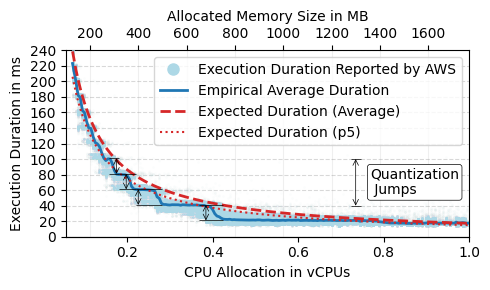

In [15]:
fig, ax = plt.subplots(figsize=(5, 3))

scatter = ax.scatter(
    x=scatter_x,
    y=scatter_y,
    label='Execution Duration Reported by AWS',
    alpha=0.02,
    s=1,
    c='lightblue',
    rasterized=True,
    zorder=5
)

ax.plot(
    [pair[0] for pair in memory_vs_avg_execution_duration_pair_list_by_aws],
    [pair[1] for pair in memory_vs_avg_execution_duration_pair_list_by_aws],
    label='Empirical Average Duration',
    linestyle='-',
    linewidth=2,
    alpha=1,
    zorder=8,
    color='tab:blue'
)

ax.plot(
    [pair[0] for pair in memory_vs_execution_duration_pair_list_by_proportion],
    [pair[1] for pair in memory_vs_execution_duration_pair_list_by_proportion],
    label='Expected Duration (Average)',
    linestyle='dashed',
    linewidth=2,
    alpha=1,
    zorder=10,
    color='tab:red'
)

ax.plot(
    [pair[0] for pair in memory_vs_execution_duration_pair_list_by_proportion_p5_quantile],
    [pair[1] for pair in memory_vs_execution_duration_pair_list_by_proportion_p5_quantile],
    linestyle='dotted',
    alpha=1,
    zorder=10,
    color='tab:red',
    label='Expected Duration (p5)'
)


custom_scatter = Line2D(
    [0], [0],
    marker='o',
    color='lightblue',
    label='Execution Duration Reported by AWS',
    markersize=8,
    markerfacecolor='lightblue',
    alpha=1,
    linestyle='None'
)

handles, labels = ax.get_legend_handles_labels()
handles = [
    custom_scatter if lbl == 'Execution Duration Reported by AWS' else h
    for h, lbl in zip(handles, labels)
]
ax.legend(handles=handles, loc='upper right')


ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xlabel('Allocated Memory Size in MB')



ax.yaxis.set_major_locator(ticker.MultipleLocator(20))

secax = ax.secondary_xaxis(
    'bottom',
    functions=(lambda x: x / 1769, lambda x: x * 1769)
)
secax.set_xlabel('CPU Allocation in vCPUs')

ax.set_ylabel('Execution Duration in ms')
ax.set_xlim(100, 1769)
ax.set_ylim(0, 240)
ax.grid(axis='y', color='grey', linestyle='--', linewidth=0.8, alpha=0.3, zorder=1)
ax.grid(axis='x', alpha=0.2, zorder=0)

draw_vertical_double_arrow(ax, x=310, y_range=(81, 101), bar_range=(280, 320), linewidth=0.5, color='black', zorder=1000)
draw_vertical_double_arrow(ax, x=350, y_range=(61, 81), bar_range=(320, 390), linewidth=0.5, color='black', zorder=1000)
draw_vertical_double_arrow(ax, x=400, y_range=(41, 61), bar_range=(390, 500), linewidth=0.5, color='black', zorder=1000)
draw_vertical_double_arrow(ax, x=680, y_range=(21, 41), bar_range=(650, 750), linewidth=0.5, color='black', zorder=1000)

draw_vertical_measure(
    ax,
    x=1300,
    y_range=(40, 100),
    label='Quantization\n Jumps',
    color='black',
    bar_width=40,
    linewidth=0.5,
    zorder=10,
    text_offset=(60, 0)
)

plt.tight_layout()
fig.savefig('figures/overallocation_aws.pdf')
print("Figure saved to figures/overallocation_aws.pdf")
plt.show()